In [1]:
import utils
from modelscope.pipelines import pipeline
from modelscope.utils.constant import ModelFile, Tasks

device = "cpu"

det_model_id = 'damo/cv_resnet50_face-detection_retinaface'
bbox_detector = pipeline(Tasks.face_detection, model=det_model_id, device=device)
bbox_detector.detector.to(device)

def bbox_detects(rgb_image):
    det_results = bbox_detector(rgb_image)
    results = []
    for i in range(len(det_results['scores'])):
        info_dict = {}
        info_dict['bbox'] = np.array(det_results['boxes'][i]).astype(
            np.int32).tolist()
        info_dict['score'] = det_results['scores'][i]
        info_dict['landmarks'] = np.array(
            det_results['keypoints'][i]).astype(np.int32).reshape(
            5, 2).tolist()
        results.append(info_dict)
    crop_bboxes = utils.get_crop_bbox(results)
    return crop_bboxes


/home/dev/anaconda3/envs/LivePortrait/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-03 00:27:50,122 - modelscope - WARNING - Model revision not specified, use revision: v2.0.2


2025-02-03 00:27:51,029 - modelscope - INFO - initiate model from /home/dev/.cache/modelscope/hub/damo/cv_resnet50_face-detection_retinaface
2025-02-03 00:27:51,031 - modelscope - INFO - initiate model from location /home/dev/.cache/modelscope/hub/damo/cv_resnet50_face-detection_retinaface.
2025-02-03 00:27:51,038 - modelscope - WARNING - No preprocessor field found in cfg.
2025-02-03 00:27:51,038 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2025-02-03 00:27:51,039 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': '/home/dev/.cache/modelscope/hub/damo/cv_resnet50_face-detection_retinaface'}. trying to build by task and model information.
2025-02-03 00:27:51,040 - modelscope - WARNING - Find task: face-detection, model type: None. Insufficient information to build preprocessor, skip building preprocessor
2025-02-03 00:27:51,044 - modelscope - INFO - loa

In [14]:
import torch
from modelscope.models.cv.skin_retouching.detection_model.detection_unet_in import \
    DetectionUNet
from modelscope.models.cv.skin_retouching.inpainting_model.inpainting_unet import \
    RetouchingNet

inpainting_net = RetouchingNet(
    in_channels=4, out_channels=3).to(device)
detection_net = DetectionUNet(
    n_channels=3, n_classes=1).to(device)

det_path = "pretrain_checkpoints/det.pth"
inp_path = "pretrain_checkpoints/inp.pth"

detection_net_ckpt_dict_load = torch.load(det_path, map_location='cpu')
detection_net.load_state_dict(detection_net_ckpt_dict_load['state_dict'])

inp_net_ckpt_dict_load = torch.load(inp_path, map_location='cpu')
inpainting_net.load_state_dict(inp_net_ckpt_dict_load['state_dict'])

detection_net.eval()
inpainting_net.eval()
print("")

In [15]:
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import Any, Dict
from modelscope.pipelines.base import Input, Pipeline
from modelscope.preprocessors import LoadImage

# img_path = "examples/im.png"
img_path = "examples/skin_retouching_examples_1.jpg"
img = Image.open(img_path)
im = LoadImage.convert_to_ndarray(img)
rgb_image = im.astype(np.uint8)
bboxes = bbox_detects(rgb_image)  
bbox = bboxes[0]

In [16]:
def img_postprocess(img):
    img = img.permute(0, 2, 3, 1)
    # img = img / 2 + 0.5
    img = img * 255.
    img = img.cpu().numpy().astype(np.uint8)[0]
    h, w= img.shape[:2]
    return cv2.resize(img, (2*w, 2*h))

def retouch_local(image, sub_mask_pred):
    sub_mask_pred_hard_low = (sub_mask_pred >= 0.35).float()
    sub_mask_pred_hard_high = (sub_mask_pred >= 0.5).float()
        
    sub_mask_pred = sub_mask_pred * (
        1 - sub_mask_pred_hard_high) + sub_mask_pred_hard_high
    sub_mask_pred = sub_mask_pred * sub_mask_pred_hard_low
    sub_mask_pred = 1 - sub_mask_pred

    # image to rgb
    image_origin = image
    image_origin = image_origin / 2 + 0.5
    image_input = image_origin * sub_mask_pred

    # rgb to internal image
    # image_input = (image_input - 0.5) * 2
    image_input = F.interpolate(image_input, size=(512, 512), mode='nearest')        
    image_origin = F.interpolate(image_origin, size=(512, 512), mode='nearest')
    mask_pred_input = sub_mask_pred
    mask_pred_input = F.interpolate(mask_pred_input, size=(512, 512), mode='nearest')
    
    inpainting_output = inpainting_net(image_input, mask_pred_input)

    # rgb to internal image
    # image_input = image_input / 2 + 0.5
    # inpainting_output = inpainting_output / 2 + 0.5
    inpainting_comp = image_input + (
                    1 - mask_pred_input) * inpainting_output

    return image_origin, image_input, inpainting_comp


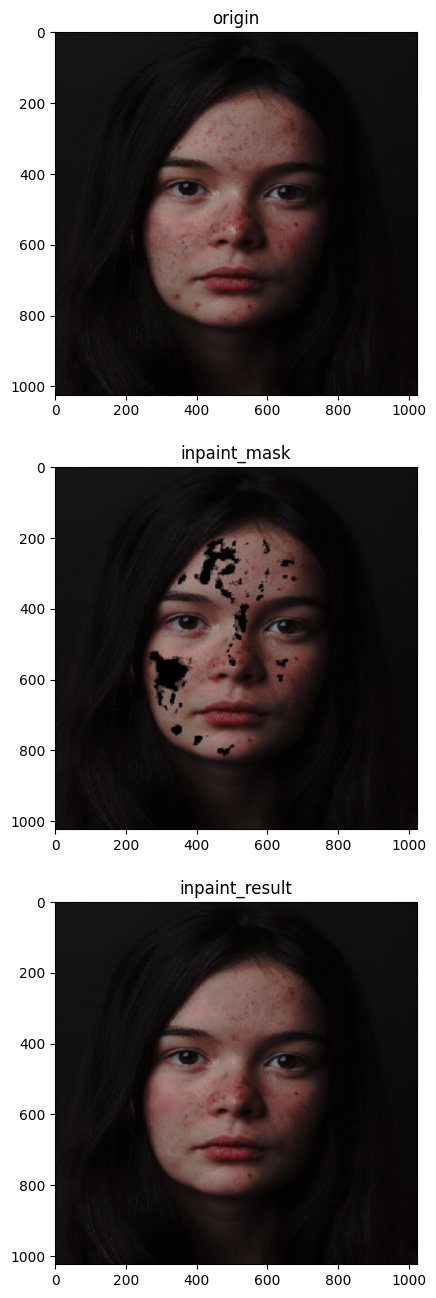

In [17]:
import utils
import cv2
import numpy as np
import torch.nn.functional as F

rgb_image = im.astype(np.uint8)
roi, expand, crop_tblr = utils.get_roi_without_padding(rgb_image, bbox)

roi = utils.roi_to_tensor(roi)
roi = roi.to(device)
roi = roi / 255.
roi = utils.preprocess_roi(roi)

with torch.no_grad():
    image = roi
    sub_H, sub_W = image.shape[2:]
    
    # pred inpainting mask
    sub_image_standard = F.interpolate(
        image, size=(768, 768), mode='bilinear', align_corners=True)
    sub_mask_pred_cus = torch.sigmoid(
        detection_net(sub_image_standard))
    sub_mask_pred_cus = F.interpolate(
        sub_mask_pred_cus, size=(sub_H, sub_W), mode='nearest')

    # inpainting 
    image_origin, image_input, inpainting_comp = retouch_local(image, sub_mask_pred_cus)

    plt.figure(figsize=(16, 16))
    
    plt.subplot(3, 1, 1)
    plt.imshow(img_postprocess(image_origin))
    plt.title('origin')
    
    plt.subplot(3, 1, 2)
    plt.imshow(img_postprocess(image_input))
    plt.title('inpaint_mask')
        
    plt.subplot(3, 1, 3)
    plt.imshow(img_postprocess(inpainting_comp))
    plt.title('inpaint_result')
    